In [32]:
import numpy as np
import tensorflow as tf
import keras
from keras import Sequential, regularizers
from keras.layers import  Dense, LSTM
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os


In [34]:
LABELS = ["2-hands punch", "1-hand punch", "Standing", "Holding"] 

current_directory = os.getcwd()

project_path= os.path.abspath(os.path.join(current_directory, "../.."))


DATASET_PATH = f"{project_path}/data/dataset/"
xDataPath = DATASET_PATH + "X_data.txt"
yDataPath = DATASET_PATH + "Y_data.txt"
nSteps = 64

Check GPU availability

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [28]:
def load_X(xPath):
    file = open(xPath, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / nSteps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

def load_y(yPath):
    file = open(yPath, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
  
    return y_ 

Load and Split data

In [ ]:
xData = load_X(xDataPath)
yData = load_y(yDataPath)

xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.2, stratify=yData, shuffle=True)
xTest, xVal, yTest, yVal = train_test_split(xTest, yTest, test_size=0.5, stratify=yTest, shuffle=True)

Save the splitted data

In [5]:
np.save(f"{DATASET_PATH}splitted data/X_train", xTrain)
np.save(f"{DATASET_PATH}splitted data/Y_train", yTrain)
np.save(f"{DATASET_PATH}splitted data/X_val", xVal)
np.save(f"{DATASET_PATH}splitted data/Y_val", yVal)
np.save(f"{DATASET_PATH}splitted data/X_test", xTest)
np.save(f"{DATASET_PATH}splitted data/Y_test", yTest)

Load the splitted data

In [ ]:
# xTrain = np.load(f"{DATASET_PATH}splitted data/X_train.npy")
# yTrain = np.load(f"{DATASET_PATH}splitted data/Y_train.npy")
# xVal = np.load(f"{DATASET_PATH}splitted data/X_val.npy")
# yVal = np.load(f"{DATASET_PATH}splitted data/Y_val.npy")
# xTest = np.load(f"{DATASET_PATH}splitted data/X_test.npy")
# yTest = np.load(f"{DATASET_PATH}splitted data/Y_test.npy")

# print(xTrain.shape)
# print(yTrain.shape)
# print(xVal.shape)
# print(yVal.shape)
# print(xTest.shape)
# print(yTest.shape)

Set the parameters

In [142]:
nInput = 34
nHidden = 34 
nClasses = 4
learningRate = 1e-4
lambdaLossAmount = 0.0015
epochs = 300
batchSize = 100

Build the model

In [147]:
LSTM_Model = Sequential([
    
    Dense(nHidden, activation="relu", kernel_initializer="random_normal", bias_initializer="random_normal", batch_input_shape=(batchSize, nSteps, nInput)),
    LSTM(128, return_sequences=True, unit_forget_bias=1.0),
    LSTM(64,return_sequences=True, unit_forget_bias=1.0),
    LSTM(34,return_sequences=True, unit_forget_bias=1.0),
    LSTM(34, unit_forget_bias=1.0),
    Dense(64, activation='relu'),
    Dense(nClasses, activation="softmax", kernel_initializer="random_normal", bias_initializer="random_normal",
				  kernel_regularizer=regularizers.l2(lambdaLossAmount), bias_regularizer=regularizers.l2(lambdaLossAmount))
])
LSTM_Model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learningRate), metrics=["accuracy"])

In [ ]:
yTrainOneHot = keras.utils.to_categorical(yTrain, 4)
yValOneHot = keras.utils.to_categorical(yVal, 4)
trainSize = xTrain.shape[0] - xTrain.shape[0] % batchSize
valSize = xVal.shape[0] - xVal.shape[0] % batchSize
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

Train the model

In [ ]:
H = LSTM_Model.fit(
    xTrain[:trainSize,:,:],
    yTrainOneHot[:trainSize,:], 
    batch_size=batchSize, 
    epochs=epochs, 
    validation_data=(xVal[:valSize,:,:], yValOneHot[:valSize,:]), 
    shuffle=True, 
    callbacks=[callback]
)

Accuracy and Loss visualization

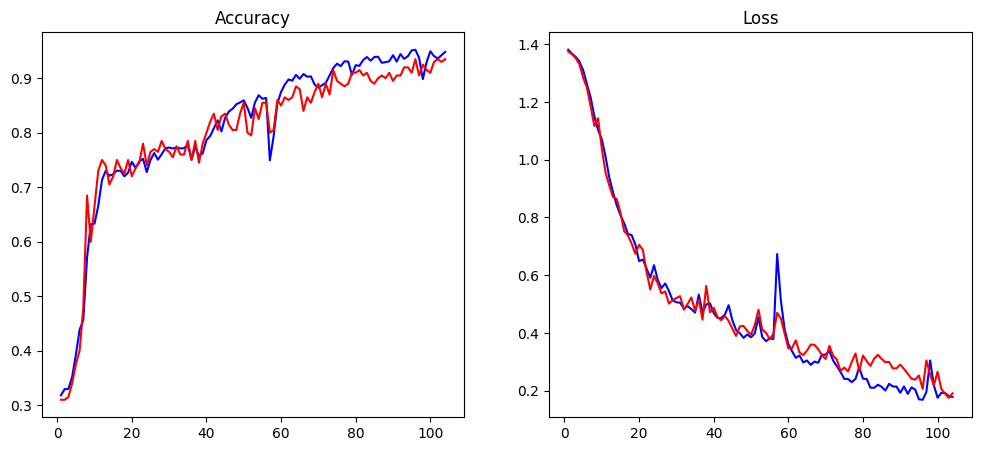

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="traning_acc")
    plt.plot(x, val_accuracy, "r", label="traning_acc")
    plt.title("Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="traning_acc")
    plt.plot(x, val_loss, "r", label="traning_acc")
    plt.title("Loss")
    
plot_history(H)

Evaluate the model

In [ ]:
from sklearn.metrics import classification_report

yPred =  LSTM_Model.predict(xTest).argmax(axis=1)
print(yPred.shape)

print(classification_report(y_true=yTest, y_pred=yPred, target_names=LABELS))

Save the model

In [ ]:
LSTM_Model.save('model\\best\\model.keras')